In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import matplotlib
plt.style.use('ggplot')
from matplotlib.pyplot import figure

%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (12,8)

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report, f1_score, precision_score, recall_score, make_scorer

from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.ensemble import BalancedBaggingClassifier
import xgboost as xgb

from sklearn.decomposition import PCA
from scipy.sparse import coo_matrix, hstack, vstack

pd.options.mode.chained_assignment = None

In [2]:
data = pd.read_csv('application_data.csv', header=0)
print(data.shape)
print(data.dtypes)

(307511, 122)
SK_ID_CURR                      int64
TARGET                          int64
NAME_CONTRACT_TYPE             object
CODE_GENDER                    object
FLAG_OWN_CAR                   object
                               ...   
AMT_REQ_CREDIT_BUREAU_DAY     float64
AMT_REQ_CREDIT_BUREAU_WEEK    float64
AMT_REQ_CREDIT_BUREAU_MON     float64
AMT_REQ_CREDIT_BUREAU_QRT     float64
AMT_REQ_CREDIT_BUREAU_YEAR    float64
Length: 122, dtype: object


In [3]:
def df_cleaner(df,null_rate=0.3,cat_limit=2):
    #filtering columns based on missing data
    total_col=[]
    for col in df.columns:
        if np.mean(data[col].isnull())<=null_rate:
            total_col.append(col)
    #finding numerical and categorical columns:        
    numeric_cols = list(df[total_col].select_dtypes(include=[np.number]).columns.values) 
    non_numeric_cols = list(df[total_col].select_dtypes(exclude=[np.number]).columns.values)
    #adding columns that have limited uniqe values to categorical columns:
    info = df[numeric_cols].nunique()
    for name , num in zip(info.index,info):
        if num<=cat_limit:
            non_numeric_cols.append(name)
    #Changing Categrorical Columns to String:
    non_numeric_cols.remove('TARGET')
    for col in non_numeric_cols:
        df[col]=df[col].apply(str)
    #Extracting numerical columns and removing TARGET and SK_ID_CURR columns    
    numeric_cols =list(set(total_col)-set(non_numeric_cols))
    numeric_cols.remove('TARGET')
    numeric_cols.remove('SK_ID_CURR')
    total_col.remove('SK_ID_CURR')
    #Imputing missing values
    imp = IterativeImputer(max_iter=10, random_state=123)
    imp.fit(df[numeric_cols])
    df[numeric_cols] = imp.transform(df[numeric_cols])
    df[non_numeric_cols].fillna('None', inplace=True)
    #Scaling numerical columns the columns
    scaler = StandardScaler()
    df[numeric_cols]=scaler.fit_transform(data[numeric_cols].values)
    
    
    return(df[total_col],numeric_cols,non_numeric_cols)
    

In [4]:
df, numeric_cols, non_numeric_cols = df_cleaner(data)

In [5]:
def vis_corr(df,cat_col):
    encoder=LabelEncoder()
    df[cat_col]= df[cat_col].apply(encoder.fit_transform)
    correlation_col=df.corr().loc['TARGET'].sort_values(ascending=False)
    plt.figure(figsize=(20,8))
    sns.barplot(correlation_col.index[1:], correlation_col.values[1:] )
    plt.title('CORRELATION BETWEEN TARGET COLUMN AND THE OTHER COLUMNS IN DATAFRAME')
    plt.xticks(rotation=90)

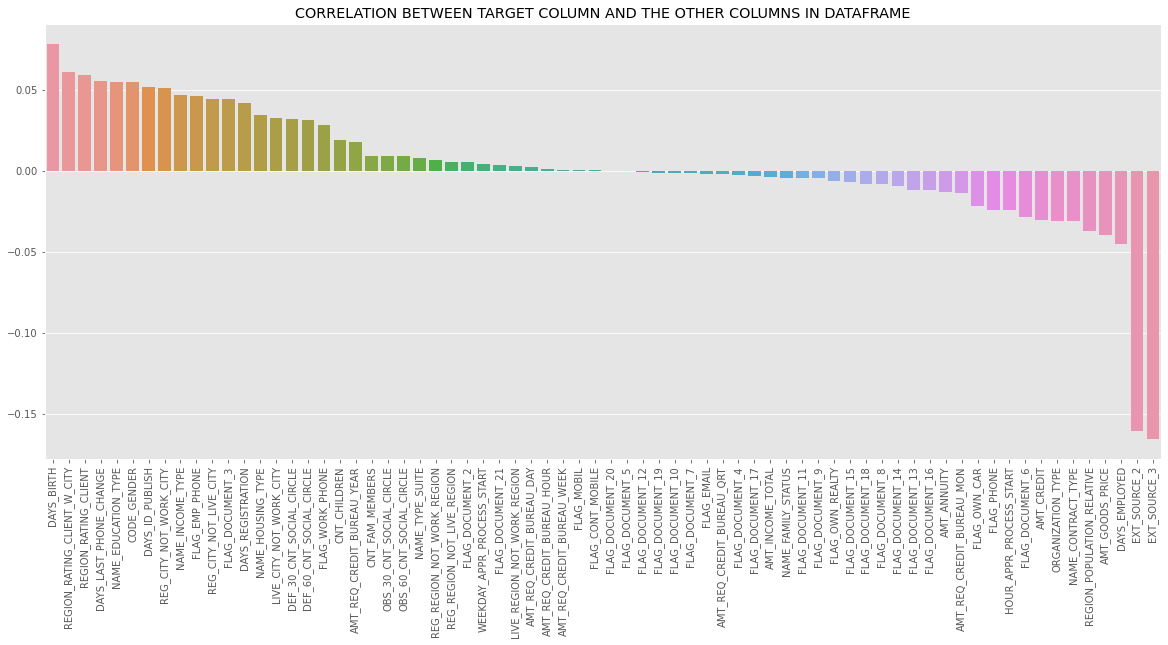

In [6]:
vis_corr(df,non_numeric_cols)

In [7]:
def intializing_for_training(df,cat_col,filter_ratio=0.02):
    """This Function would One hot encode the categorical columns of our dataframe and 
    also filters out features that have correlation ratio less than filter_ratio."""
    #Initializing label enconder
    encoder=LabelEncoder()
    df[cat_col]= df[cat_col].apply(encoder.fit_transform)
    #Extracting features with correlation value more than filter_ratio
    corr_col=df.corr().loc['TARGET'].sort_values(ascending=False)
    total_col = list(corr_col[abs(corr_col.values)>0.02].index)
    cat_col = [x for x in total_col if x in cat_col]
    #One-Hot-Encoding the categorical columns
    enc = OneHotEncoder()
    X_cat= enc.fit_transform(df[cat_col])
    #Extracting the names of the categorical columns and modifying the names of them.
    cat_col1=list(enc.get_feature_names())
    cat_col2=[]
    for i,x in enumerate(cat_col):
        name='x'+str(i)
        if i==0:
            for col in cat_col1:
                new_col=col.replace(name,x)
                cat_col2.append(new_col)
        else:
            cat_col1=cat_col2
            cat_col2=[]
            for col in cat_col1:
                new_col=col.replace(name,x)
                cat_col2.append(new_col)
    #creating the list of all column names        
    num_col = list(set(total_col)-set(cat_col))
    num_col.remove('TARGET')
    col_names = cat_col2+num_col
    X_num= df[num_col].values
    X =hstack([X_num,X_cat]).toarray()
    y =df.TARGET.values
    
    return(X,y,col_names)

In [8]:
X,y, X_names = intializing_for_training(df,non_numeric_cols, filter_ratio=0)

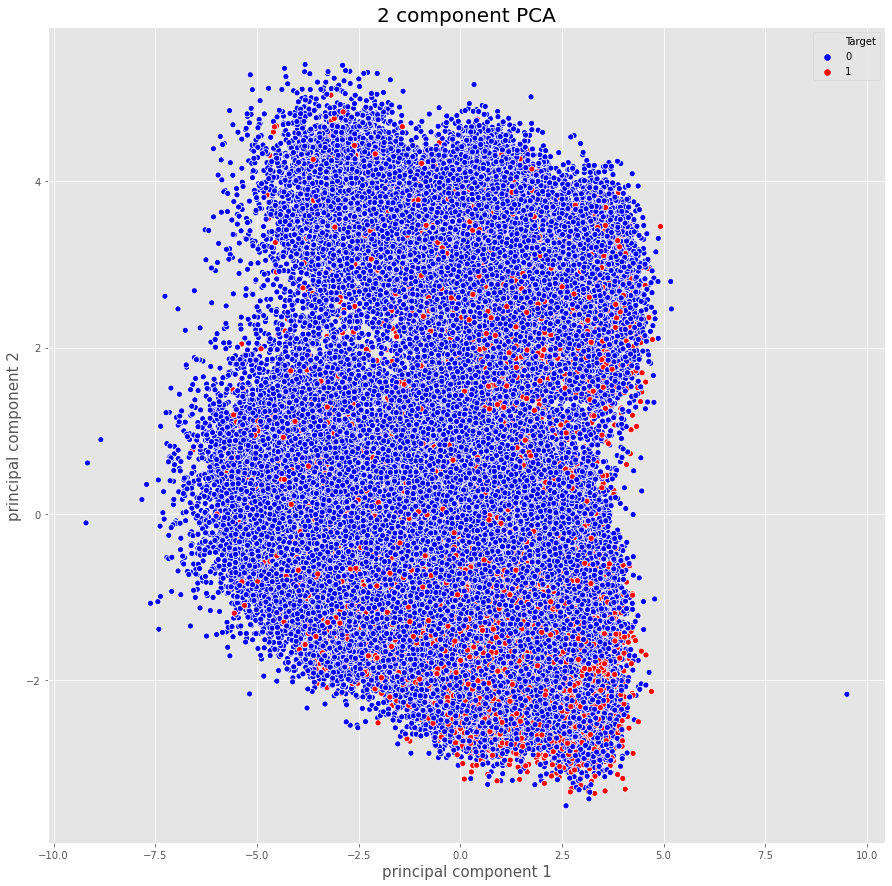

In [9]:
#Performin PCA anlysis to visualize our dataset.
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(X)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2'])

principalDf['Target']=y

fig = plt.figure(figsize = (15,15))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
sns.scatterplot(x='principal component 1',y='principal component 2',data=principalDf, hue='Target',
                palette={0:"b", 1:"r" })

In [10]:
#Splitting data into training and testing sets
X_train, X_test, y_train, y_test= train_test_split(X, y, 
                                                    train_size=0.07,
                                                    test_size=0.3,
                                                    random_state=111,
                                                    stratify=y)

In [11]:
def feature_imp(model,X_names,num=30):
    """ This function creates a plot showing the feature importance of the model provided to it"""
    importance = list(model.feature_importances_)
    importance,X_names = zip(*sorted(zip(importance, X_names),reverse=True))
    importance=list(importance)
    X_names=list(X_names)
    plt.figure(figsize=(20,8))
    sns.barplot(x=X_names[:num],y=importance[:num])
    plt.xticks(rotation=90)
    #return(importance,X_names)

In [12]:
def report(model, X_train, y_train, X_test, y_test):
    """This function creates trains and tests given model and prints the accuracy report"""
    model.fit(X_train, y_train)
    y_tr_predict = model.predict(X_train)
    print("Model Training Score")
    print(classification_report(y_train, y_tr_predict))
    
    y_test_predict = model.predict(X_test)
    print("Model Test Score")
    print(classification_report(y_test, y_test_predict))
    
    
    return(model)
    

In [13]:
model = report(xgb.XGBClassifier(scale_pos_weight=5),X_train, y_train, X_test, y_test)

Model Training Score
              precision    recall  f1-score   support

           0       0.99      0.98      0.98     19787
           1       0.76      0.88      0.81      1738

    accuracy                           0.97     21525
   macro avg       0.87      0.93      0.90     21525
weighted avg       0.97      0.97      0.97     21525

Model Test Score
              precision    recall  f1-score   support

           0       0.93      0.95      0.94     84807
           1       0.23      0.18      0.20      7447

    accuracy                           0.88     92254
   macro avg       0.58      0.57      0.57     92254
weighted avg       0.87      0.88      0.88     92254



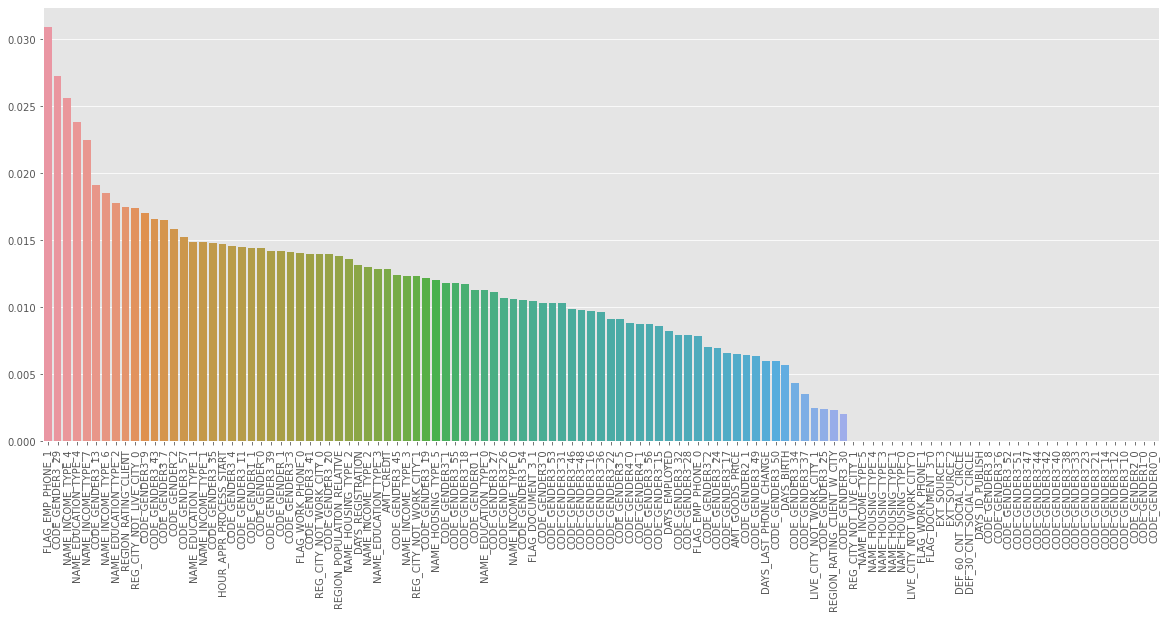

In [14]:
feature_imp(model,X_names, num=120)

In [15]:
def feature_analyser(model,X_train, y_train,X_test, y_test,X_names,steps=10,num=5):
    """This function runs the model on given X_train and y_train data sets and evaluate the model performance for the rare
    class. The function reduces the last num features based on their importance and stores the values for the columns used
    and the score of the dataset in a data frame. It iterates based on the number of steps provided to it."""
    
    columns = ['f1_score', 'recall', 'precision']+X_names
    df=pd.DataFrame(columns=columns, data=np.zeros((steps,len(columns))))
    for i in range(steps):
        model.fit(X_train, y_train)
        y_predict= model.predict(X_test)
        df['f1_score'][i] = f1_score(y_test, y_predict)
        df['recall'][i]= recall_score(y_test,y_predict)
        df['precision'][i] = precision_score(y_test,y_predict)
        for col in X_names:
            df[col][i]=1  
        importance = list(model.feature_importances_)
        j = np.argsort(importance)
        X_train = X_train[:,j][:,num:]
        X_test = X_test[:,j][:,num:]
        X_names= list( X_names[i] for i in j )
        X_names=X_names[num:]
    return(df)

In [16]:
df=feature_analyser(model,X_train,y_train,X_test,y_test,X_names,steps=22)
df

,f1_score,recall,precision,NAME_EDUCATION_TYPE_0,NAME_EDUCATION_TYPE_1,NAME_EDUCATION_TYPE_2,NAME_EDUCATION_TYPE_3,NAME_EDUCATION_TYPE_4,CODE_GENDER_0,CODE_GENDER_1,...,DAYS_BIRTH,AMT_CREDIT,DEF_30_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,REGION_POPULATION_RELATIVE,HOUR_APPR_PROCESS_START,DAYS_EMPLOYED,DAYS_ID_PUBLISH,DAYS_REGISTRATION,EXT_SOURCE_3
0,0.204483,0.184370,0.229522,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
1,0.199147,0.175507,0.230146,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0
2,0.201175,0.179401,0.228963,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0
3,0.195570,0.173090,0.224760,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0
4,0.206825,0.187592,0.230452,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0
5,0.199132,0.175507,0.230106,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0
6,0.199086,0.175507,0.229984,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0
7,0.199086,0.175507,0.229984,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0
8,0.198970,0.176313,0.228308,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0
9,0.207253,0.183027,0.238871,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0


In [17]:
def X_extractor(X,df_row):
    """This function extracts the features given to it in in df_row which is the data frame that was produced
    by function feature_analyzer"""
    index=[]
    X_name=[]
    for i, col in enumerate(df_row.index[3:]):
        if df_row[col].all():
            index.append(i)
            X_name.append(col)
            
    return(X[:,index],X_name)
            

In [18]:
X_filtered,X_name_filtered = X_extractor(X,df.iloc[19])

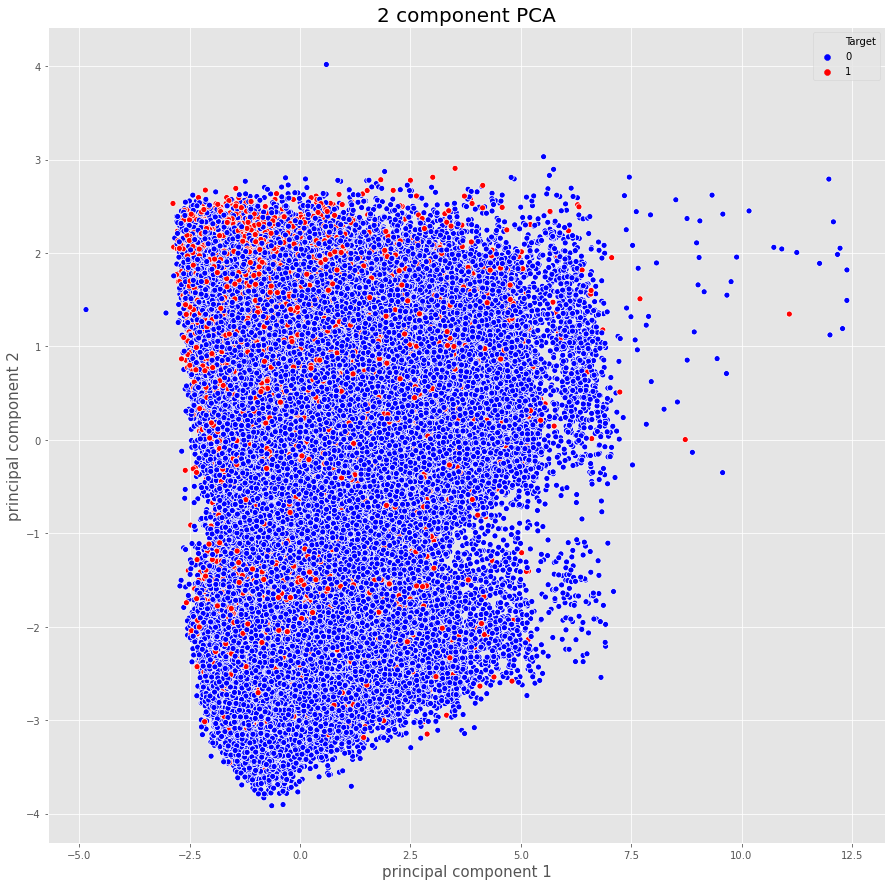

In [19]:
#Performin PCA anlysis to visualize our dataset with reduced columns.
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(X_filtered)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2'])

principalDf['Target']=y

fig = plt.figure(figsize = (15,15))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
sns.scatterplot(x='principal component 1',y='principal component 2',data=principalDf, hue='Target',
                palette={0:"b", 1:"r" })

It seems that the scatterness of the fraud points have become less

In [20]:
X_train, X_test, y_train, y_test= train_test_split(X_filtered, y, 
                                                    train_size=0.07,
                                                    test_size=0.3,
                                                    random_state=111,
                                                    stratify=y)

In [21]:
def imb_over(model,X_train,y_train,X_test,y_test,ratios, strategy='SMOTE'):
    """This function uses the methods of SMOTE and oversampling with different ratios and produces a dataframe with
    the results"""
    columns = ['ratio','f1_score', 'recall', 'precision']
    df=pd.DataFrame(columns=columns, data=np.zeros((len(ratios),4)))
    
    for i,rate in enumerate(ratios):
        if strategy == 'SMOTE':
            oversample = SMOTE(sampling_strategy=rate)
        if strategy == 'Over':
            oversample = RandomOverSampler(sampling_strategy=rate)
        X1, y1 = oversample.fit_resample(X_train,y_train)
        model.fit(X1, y1)
        y_predict= model.predict(X_test)
        df['ratio'][i]=rate
        df['f1_score'][i] = f1_score(y_test, y_predict)
        df['recall'][i]= recall_score(y_test,y_predict)
        df['precision'][i] = precision_score(y_test,y_predict)
    return(df)

In [22]:
model = xgb.XGBClassifier(scale_pos_weight=100)
df_smote = imb_over(model,X_train,y_train,X_test,y_test,np.arange(0.1,1,.05))
df_smote

,ratio,f1_score,recall,precision
0,0.10,0.200375,0.689137,0.117231
1,0.15,0.198487,0.694239,0.115797
2,0.20,0.192674,0.704579,0.111596
3,0.25,0.193961,0.715993,0.112175
4,0.30,0.195102,0.714113,0.112985
5,0.35,0.193161,0.710353,0.111778
6,0.40,0.191105,0.716933,0.110246
7,0.45,0.187645,0.730764,0.107643
8,0.50,0.190347,0.726064,0.109531
9,0.55,0.188046,0.718813,0.108172


In [23]:
df_over = imb_over(model,X_train,y_train,X_test,y_test,np.arange(0.1,1,.05),strategy='Over')
df_over

,ratio,f1_score,recall,precision
0,0.10,0.196984,0.656103,0.115889
1,0.15,0.197705,0.660534,0.116250
2,0.20,0.193340,0.656103,0.113375
3,0.25,0.194736,0.695985,0.113205
4,0.30,0.189628,0.691822,0.109872
5,0.35,0.189541,0.668457,0.110426
6,0.40,0.191327,0.679871,0.111329
7,0.45,0.187385,0.688331,0.108455
8,0.50,0.190368,0.695851,0.110267
9,0.55,0.187293,0.708742,0.107904


In [24]:
#Using the Balanced Bagging Classifier
bbc = BalancedBaggingClassifier(base_estimator=xgb.XGBClassifier(scale_pos_weight=5),
                                sampling_strategy='auto',
                                replacement=False,
                                random_state=0)

model=report(bbc,X_train, y_train, X_test, y_test)

Model Training Score
              precision    recall  f1-score   support

           0       1.00      0.60      0.75     19787
           1       0.18      0.99      0.30      1738

    accuracy                           0.63     21525
   macro avg       0.59      0.79      0.53     21525
weighted avg       0.93      0.63      0.71     21525

Model Test Score
              precision    recall  f1-score   support

           0       0.96      0.57      0.72     84807
           1       0.13      0.73      0.22      7447

    accuracy                           0.59     92254
   macro avg       0.55      0.65      0.47     92254
weighted avg       0.89      0.59      0.68     92254



In [25]:

recall = make_scorer(recall_score)
param_grid= {"learning_rate"    : [0.05, 0.10, 0.15, 0.20, 0.25, 0.30 ] ,
             "max_depth"        : [5, 6, 8, 10, 12, 15],
             "min_child_weight" : [ 1, 3, 5, 7 ],
             "gamma"            : [ 0.0, 0.1, 0.2 , 0.3, 0.4 ],
             "colsample_bytree" : [ 0.3, 0.4, 0.5 , 0.7 ],
             "scale_pos_weight" : [5]}

gsc = GridSearchCV(estimator=xgb.XGBClassifier(),
                   param_grid=param_grid,
                   scoring=recall)

gsc.fit(X_train,y_train)

GridSearchCV(estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None...
                                     reg_alpha=None, reg_lambda=None,
                                     scale_pos_weight=None, subsample=None,
                                     tree_method=None, validate_parameters=None,
                                     verbosity=None),
             par

In [26]:
best_params = gsc.best_params_

print(best_params)

{'colsample_bytree': 0.7, 'gamma': 0.0, 'learning_rate': 0.05, 'max_depth': 5, 'min_child_weight': 3, 'scale_pos_weight': 5}


In [27]:
bbc = BalancedBaggingClassifier(base_estimator=xgb.XGBClassifier(scale_pos_weight=25,
                                                                 learning_rate= 0.05,
                                                                 colsample_bytree= .7,
                                                                 max_depth= 5,
                                                                 min_child_weight=3,
                                                                 reg_lambda=1),
                                sampling_strategy='auto',
                                replacement=False,
                                random_state=0)

model=report(bbc,X_train, y_train, X_test, y_test)

Model Training Score
              precision    recall  f1-score   support

           0       1.00      0.03      0.05     19787
           1       0.08      1.00      0.15      1738

    accuracy                           0.10     21525
   macro avg       0.54      0.51      0.10     21525
weighted avg       0.93      0.10      0.06     21525

Model Test Score
              precision    recall  f1-score   support

           0       0.99      0.02      0.05     84807
           1       0.08      1.00      0.15      7447

    accuracy                           0.10     92254
   macro avg       0.53      0.51      0.10     92254
weighted avg       0.91      0.10      0.06     92254



In [28]:
model = report(xgb.XGBRFClassifier(scale_pos_weight=32,
        learning_rate= 0.05,
        colsample_bytree= .7,
        max_depth= 3,
        min_child_weight=3,
        reg_lambda=1),
        X_train, y_train, X_test, y_test)

Model Training Score
              precision    recall  f1-score   support

           0       0.99      0.02      0.03     19787
           1       0.08      1.00      0.15      1738

    accuracy                           0.10     21525
   macro avg       0.54      0.51      0.09     21525
weighted avg       0.92      0.10      0.04     21525

Model Test Score
              precision    recall  f1-score   support

           0       0.98      0.02      0.03     84807
           1       0.08      1.00      0.15      7447

    accuracy                           0.09     92254
   macro avg       0.53      0.51      0.09     92254
weighted avg       0.91      0.09      0.04     92254



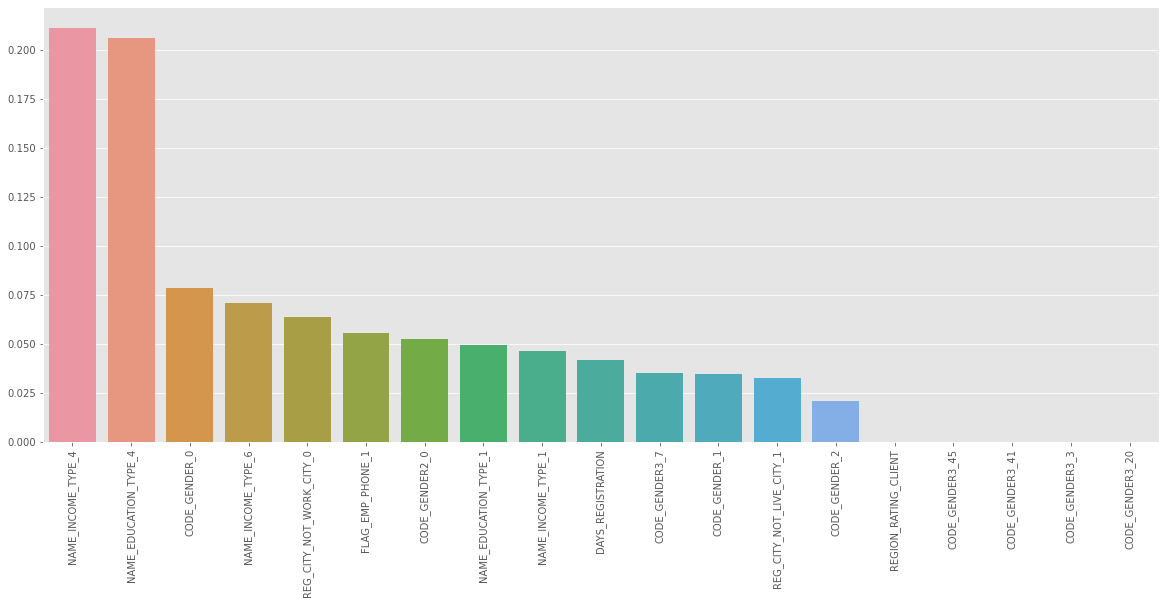

In [29]:
feature_imp(model,X_name_filtered, num=19)